In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.special as sci
np.random.seed(1234)
tf.set_random_seed(1234)
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import pickle
import pandas as pd

# MET_forward

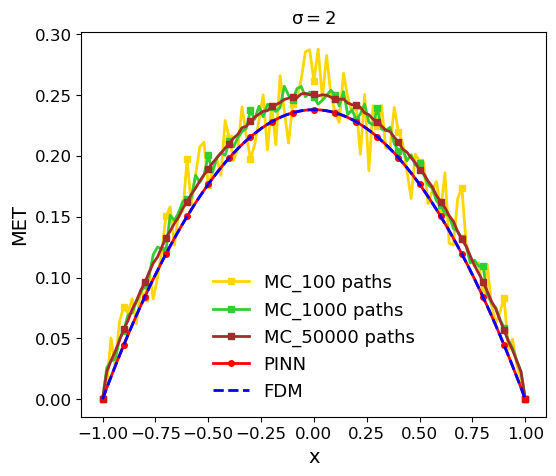

In [9]:
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H = X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y
#W*H+b

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64)
#给出初始weight服从标准正态分布，in_dim行*out_dim列



def net_u(xu, weights, biases):
#    u = neural_net(tf.concat([xu], 1), weights, biases)
    u = (xu-x0) * (x1-xu) *neural_net(xu, weights, biases)
    return u


def net_f(xf, weights,biases):
    u =(xf-x0) * (x1-xf) * neural_net(xf, weights, biases)
    u_x = tf.gradients(u, xf)[0]
    u_xx = tf.gradients(u_x, xf)[0]
    return (xf-xf**3)*u_x+0.5*u_xx


def u_exact(x):
    return np.sin(np.pi*x)

def f_exact(x):
    return -1
layers = [1] + 4 * [20] + [1]
L = len(layers)

weights = [xavier_init([layers[l], layers[l + 1]]) for l in range(0, L - 1)]
biases = [tf.Variable(tf.zeros((1, layers[l + 1]), dtype=tf.float64)) for l in range(0, L - 1)]
x0, x1 = -1,1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # 初始化所有变量

    # 加载权重
    with open(r"D:\new\code\MC-FDM-PINN\1d\met\met_forward_weight_sigma2\metforward_hyper_best_model.pkl", "rb") as f:
        sample_list = pickle.load(f)

    weights_u_np = sample_list["weights_u"]
    biases_u_np = sample_list["biases_u"]

    # 将权重分配给变量
    for i in range(len(weights)):
#         print(f"Weights_u[{i}] expected shape: {weights_u[i].shape}, loaded shape: {weights_u_np[i].shape}")
#         print(f"Biases_u[{i}] expected shape: {biases_u[i].shape}, loaded shape: {biases_u_np[i].shape}")

        sess.run(weights[i].assign(weights_u_np[i]))
        sess.run(biases[i].assign(biases_u_np[i]))


    # 使用加载的权重进行预测
    x_test = np.reshape(np.linspace(x0, x1, 101), [-1, 1])
    u_pred = net_u(tf.to_double(x_test),  weights, biases)
    u_pred_2 = sess.run(u_pred)
    
data2_100 = np.load(r"D:\new\code\MC-FDM-PINN\1d\met\sigma2met_MC_100_101.npz")
t_need2_100 = data2_100['t_need']
x_02_100= data2_100['x_0']

data2_5w = np.load(r"D:\new\code\MC-FDM-PINN\1d\met\sigma2met_MC.npz")
t_need2_5w = data2_5w['t_need']
x_02_5w = data2_5w['x_0']

data2_1000 = np.load(r"D:\new\code\MC-FDM-PINN\1d\met\sigma2met_MC_1000_101.npz")
t_need2_1000 = data2_1000['t_need']
x_02_1000 = data2_1000['x_0']

X2 = pd.read_csv(r"D:\new\code\MC-FDM-PINN\1d\met\1dmet_sigma2_FDM_X.csv", header=None).values.flatten()
U2 = pd.read_csv(r"D:\new\code\MC-FDM-PINN\1d\met\1dmet_sigma2_FDM__U.csv", header=None).values.flatten()


plt.figure(figsize=(6,5))

plt.plot(x_02_100, t_need2_100, label='MC_100 paths', color='gold', linestyle='-', marker='s', markersize=4, linewidth=2, markevery=5)
plt.plot(x_02_1000, t_need2_1000, label='MC_1000 paths', color='limegreen', linestyle='-', marker='s', markersize=4, linewidth=2, markevery=5)
plt.plot(x_02_5w, t_need2_5w, label='MC_50000 paths', color='brown', linestyle='-', marker='s', markersize=4, linewidth=2, markevery=5)
plt.plot(x_test, u_pred_2, label='PINN', color='red', linestyle='-', marker='o', markersize=4, linewidth=2, markevery=5)

plt.plot(X2, U2, label='FDM', color='blue', linestyle='--', markersize=4, linewidth=2, markevery=5)
plt.xlabel('x', fontsize=14)
plt.ylabel('MET', fontsize=14)
# plt.ylim(0.15, 0.25)
plt.title(r'$\mathrm{\sigma}=2$', fontsize=13)
plt.legend( frameon=False, fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig('1d_met_forward_sigma2.png')

# MET_inverse

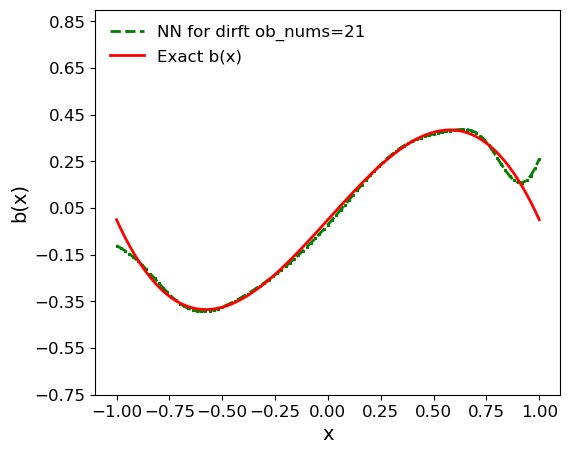

In [16]:
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H = X
    for l in range(0, num_layers - 2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y


# W*H+b

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2.0 / (in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64), dtype=tf.float64)


# 给出初始weight服从标准正态分布，in_dim行*out_dim列

def net_u(xu, weights, biases):
    # u=neural_net(xu, weights, biases)
    # u = (x1 - xu) * (-x0 + xu) * neural_net(xu, weights, biases)
    u = neural_net(xu, weights, biases)
    return u

def f_exact(x):
    return -1

def g_exact(x):
    return x-x**3

x0, x1 = -1,1
u_opt=np.loadtxt(r"D:\new\code\1dmet\met\101-ut0-met.txt")

def net_f(xf, weights_u,biases_u,weights_f,biases_f):
    u = net_u(xf, weights_u, biases_u)
    u_x = tf.gradients(u, xf)[0]
    u_xx = tf.gradients(u_x, xf)[0]
    g= neural_net(xf, weights_f, biases_f)
    return g * u_x+0.5*u_xx

layers = [1] + 4 * [20] + [1]
L = len(layers)

weights_u = [xavier_init([layers[l], layers[l+1]]) for l in range(0, L-1)]
biases_u = [tf.Variable( tf.zeros((1, layers[l+1]),dtype=tf.float64)) for l in range(0, L-1)]

#layers_f = [1] + 2 * [64] + [1]
layers_f = [1] + 4 * [20] + [1]
L_f = len(layers_f)
weights_f = [tf.Variable(tf.zeros([layers_f[l], layers_f[l+1]], dtype=tf.float64)) for l in range(L_f-1)]
biases_f = [tf.Variable(tf.zeros([1, layers_f[l+1]], dtype=tf.float64)) for l in range(L_f-1)]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # 初始化所有变量

    # 加载权重
    with open(r"D:\new\code\1dmet\met\met_inverse_drift_weight21\metinver_drift_hyper_best_model21.pkl", "rb") as f:
        sample_list = pickle.load(f)

    weights_u_np = sample_list["weights_u"]
    biases_u_np = sample_list["biases_u"]
    weights_f_np = sample_list["weights_f"]
    biases_f_np = sample_list["biases_f"]

    # 将权重分配给变量
    for i in range(len(weights_u)):
#         print(f"Weights_u[{i}] expected shape: {weights_u[i].shape}, loaded shape: {weights_u_np[i].shape}")
#         print(f"Biases_u[{i}] expected shape: {biases_u[i].shape}, loaded shape: {biases_u_np[i].shape}")

        sess.run(weights_u[i].assign(weights_u_np[i]))
        sess.run(biases_u[i].assign(biases_u_np[i]))

    for i in range(len(weights_f)):
#         print(f"Weights_f[{i}] expected shape: {weights_f[i].shape}, loaded shape: {weights_f_np[i].shape}")
#         print(f"Biases_f[{i}] expected shape: {biases_f[i].shape}, loaded shape: {biases_f_np[i].shape}")

        sess.run(weights_f[i].assign(weights_f_np[i]))
        sess.run(biases_f[i].assign(biases_f_np[i]))

    # 使用加载的权重进行预测
    x_test = np.reshape(np.linspace(x0, x1, 101), [-1, 1])
    u_pred = net_u(tf.to_double(x_test),  weights_f, biases_f)
    u_pred_21 = sess.run(u_pred)
    
    N_ob=21
    choose_ob=np.linspace(0,100,N_ob,dtype=int)
    u_ob21=u_opt[choose_ob][:,None]
    xf21 = np.reshape(np.linspace(x0,x1,N_ob),[-1,1])
    u_ob_NN21=net_u(x_test, weights_u, biases_u)
    u_ob_NN21 = sess.run(u_ob_NN21)
    
    u_pred = net_u(tf.to_double(x_test),  weights_f, biases_f)
    u_pred_5 = sess.run(u_pred)
    
##predict
plt.figure(figsize=(6,5))
plt.plot(x_test, u_pred_21, label='NN for dirft ob_nums=21', color='green', linestyle='--',marker='*',markersize=2, linewidth=2)
plt.plot(x_test, g_exact(x_test), label='Exact b(x)', color='red', linestyle='-', linewidth=2)

plt.xlabel('x',fontsize=14)
plt.ylabel('b(x)',fontsize=14)
plt.gca().set_ylim(-0.75, 0.9)
plt.yticks(np.arange(-0.75, 1.0, 0.2)) 
plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=12) 

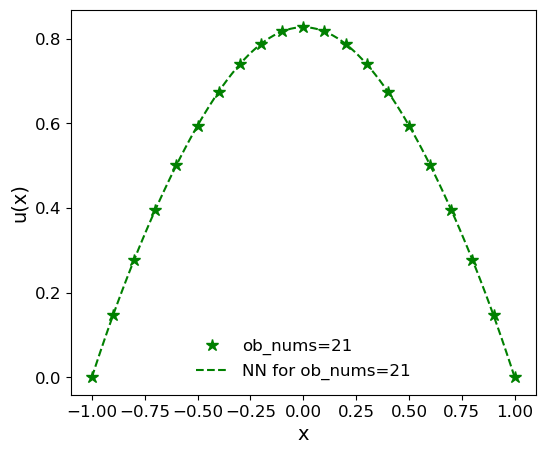

In [17]:
plt.figure(figsize=(6,5))

plt.plot(xf21, u_ob21, 'g*', label='ob_nums=21', markersize=9)
plt.plot(x_test, u_ob_NN21,'g--',label='NN for ob_nums=21', linewidth=1.5)

plt.xlabel('x', fontsize=14)
plt.ylabel('u(x)', fontsize=14)
plt.legend(loc='best',fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=12)

# EP_forward

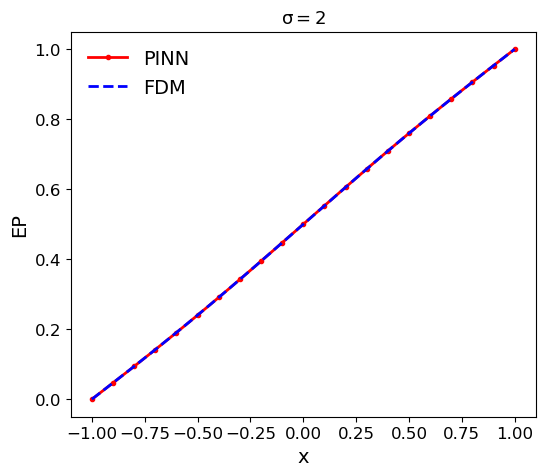

In [18]:
epX2 = pd.read_csv(r"D:\new\code\MC-FDM-PINN\1d\ep\1dep_sigma2_FDM_x.csv", header=None).values.flatten()
epU2 = pd.read_csv(r"D:\new\code\MC-FDM-PINN\1d\ep\1dep_sigma2_FDM__U.csv", header=None).values.flatten()

def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H = X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y
#W*H+b

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64)



def net_u(xu, weights, biases):
#    u = neural_net(tf.concat([xu], 1), weights, biases)
    #u =((xu-x0)/(x1-x0)) *neural_net(xu, weights, biases)
    u = (xu-x0)*neural_net(xu, weights, biases)
    return u


def net_f(xf, weights,biases):
    #u =(xf-x0) * (x1-xf) * neural_net(xf, weights, biases)
    u =(xf-x0)*neural_net(xf, weights, biases)
    # u = ((xf-x0) /2) * neural_net(xf, weights, biases)+((x1-xf)/2)
    #u = neural_net(xf, weights, biases)
    u_x = tf.gradients(u, xf)[0]
    u_xx = tf.gradients(u_x, xf)[0]

    loss_boundary = tf.reduce_mean(tf.square(u[-1] - 1))

    return (xf-xf**3)*u_x+0.5*u_xx,loss_boundary

def f_exact(x):
    return 0

def u_exact(x):
    return (x+x0)*(x1-x)


layers = [1] + 4 * [20] + [1]
L = len(layers)

weights = [xavier_init([layers[l], layers[l + 1]]) for l in range(0, L - 1)]
biases = [tf.Variable(tf.zeros((1, layers[l + 1]), dtype=tf.float64)) for l in range(0, L - 1)]
x0, x1 = -1,1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 

    with open(r"D:\new\code\MC-FDM-PINN\1d\ep\ep_forward_weight_sigma2\epforward_hyper_best_model.pkl", "rb") as f:
        sample_list = pickle.load(f)

    weights_u_np = sample_list["weights_u"]
    biases_u_np = sample_list["biases_u"]


    for i in range(len(weights)):

        sess.run(weights[i].assign(weights_u_np[i]))
        sess.run(biases[i].assign(biases_u_np[i]))

    x_test = np.reshape(np.linspace(x0, x1, 101), [-1, 1])
    u_pred = net_u(tf.to_double(x_test),  weights, biases)
    u_pred_2 = sess.run(u_pred)
    
plt.figure(figsize=(6,5))
plt.plot(x_test, u_pred_2, label='PINN', color='red', linestyle='-', marker='o', markersize=3, linewidth=2, markevery=5)

plt.plot(epX2, epU2, label='FDM', color='blue', linestyle='--', markersize=4, linewidth=2, markevery=5)
plt.xlabel('x', fontsize=14)
plt.ylabel('EP', fontsize=14)
# plt.ylim(-0.05, 2.3)
plt.title(r'$\mathrm{\sigma}=2$', fontsize=13)
plt.legend( frameon=False,fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)  

# EP_inverse

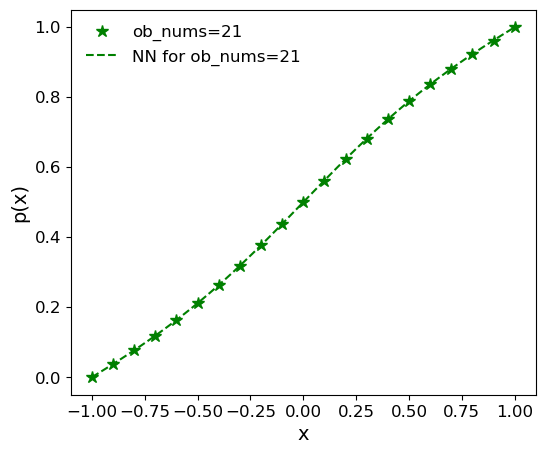

In [14]:
def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H = X
    for l in range(0, num_layers - 2):
        W = weights[l]
        b = biases[l]
        H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y


# W*H+b

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2.0 / (in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64), dtype=tf.float64)


# 给出初始weight服从标准正态分布，in_dim行*out_dim列

def net_u(xu, weights, biases):
    # u=neural_net(xu, weights, biases)
    # u = (x1 - xu) * (-x0 + xu) * neural_net(xu, weights, biases)
    u = neural_net(xu, weights, biases)
    return u

def f_exact(x):
    return 0

def g_exact(x):
    return x-x**3

x0, x1 = -1,1

u_opt=np.loadtxt(r"D:\new\code\1dmet\FEP\1001-ut0-ep.txt")

def net_f(xf, weights_u,biases_u,weights_f,biases_f):
    u = net_u(xf, weights_u, biases_u)
    u_x = tf.gradients(u, xf)[0]
    u_xx = tf.gradients(u_x, xf)[0]
    g= neural_net(xf, weights_f, biases_f)
    return g * u_x+0.5*u_xx

layers = [1] + 4 * [20] + [1]
L = len(layers)

weights_u = [xavier_init([layers[l], layers[l+1]]) for l in range(0, L-1)]
biases_u = [tf.Variable( tf.zeros((1, layers[l+1]),dtype=tf.float64)) for l in range(0, L-1)]


layers_f = [1] + 4 * [20] + [1]
L_f = len(layers_f)
weights_f = [xavier_init([layers_f[l], layers_f[l+1]]) for l in range(0, L_f-1)]
biases_f = [tf.Variable( tf.zeros((1, layers_f[l+1]),dtype=tf.float64)) for l in range(0, L_f-1)]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  

    # 加载权重
    with open(r"D:\new\code\1dmet\FEP\ep_inverse_weight21\epinver_drift_hyper_best_model21.pkl", "rb") as f:
        sample_list = pickle.load(f)

    weights_u_np = sample_list["weights_u"]
    biases_u_np = sample_list["biases_u"]
    weights_f_np = sample_list["weights_f"]
    biases_f_np = sample_list["biases_f"]

    # 将权重分配给变量
    for i in range(len(weights_u)):
#         print(f"Weights_u[{i}] expected shape: {weights_u[i].shape}, loaded shape: {weights_u_np[i].shape}")
#         print(f"Biases_u[{i}] expected shape: {biases_u[i].shape}, loaded shape: {biases_u_np[i].shape}")

        sess.run(weights_u[i].assign(weights_u_np[i]))
        sess.run(biases_u[i].assign(biases_u_np[i]))

    for i in range(len(weights_f)):
#         print(f"Weights_f[{i}] expected shape: {weights_f[i].shape}, loaded shape: {weights_f_np[i].shape}")
#         print(f"Biases_f[{i}] expected shape: {biases_f[i].shape}, loaded shape: {biases_f_np[i].shape}")

        sess.run(weights_f[i].assign(weights_f_np[i]))
        sess.run(biases_f[i].assign(biases_f_np[i]))

    x_test = np.reshape(np.linspace(x0, x1, 101), [-1, 1])
    u_pred = net_u(tf.to_double(x_test),  weights_f, biases_f)
    u_pred_21 = sess.run(u_pred)
    
    N_ob=21
    choose_ob=np.linspace(0,1000,N_ob,dtype=int)
    u_ob21=u_opt[choose_ob][:,None]
    xf21 = np.reshape(np.linspace(x0,x1,N_ob),[-1,1])
    u_ob_NN21=net_u(x_test, weights_u, biases_u)
    u_ob_NN21 = sess.run(u_ob_NN21)
    u_pred = net_u(tf.to_double(x_test),  weights_f, biases_f)
    u_pred_21 = sess.run(u_pred)
    

##predict
plt.figure(figsize=(6,5)) 

plt.plot(xf21, u_ob21, 'g*', label='ob_nums=21', markersize=9)
plt.plot(x_test, u_ob_NN21,'g--',label='NN for ob_nums=21', linewidth=1.5)


plt.xlabel('x', fontsize=14)
plt.ylabel('p(x)', fontsize=14)
plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=12)  

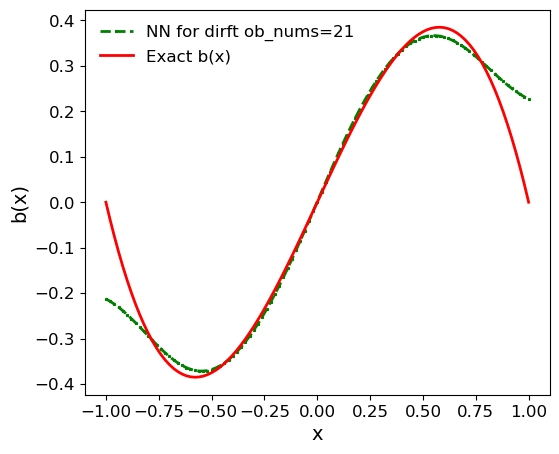

In [15]:
##drift
plt.figure(figsize=(6, 5))
plt.plot(x_test, u_pred_21, label='NN for dirft ob_nums=21',  color='green', linestyle='--',marker='*',markersize=2, linewidth=2)

plt.plot(x_test, g_exact(x_test), label='Exact b(x)', color='red', linestyle='-', linewidth=2)

plt.xlabel('x',fontsize=14)
plt.ylabel('b(x)',fontsize=14)
# plt.title('Met inverse problem')
plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=12) 